<a href="https://colab.research.google.com/github/toshif/colab1/blob/main/jax_lstm_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/deepmind/dm-haiku/blob/main/examples/haiku_lstms.ipynb

In [2]:
!pip install git+https://github.com/deepmind/dm-haiku

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-qoj6o9hw
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-qoj6o9hw
  Created wheel for dm-haiku: filename=dm_haiku-0.0.6.dev0-py3-none-any.whl size=537308 sha256=ae31440676d1713128cfca8e400c91fa8599a0945dd43ab708c4d659840b98bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-4i9p08qp/wheels/06/28/69/ebaac5b2435641427299f29d88d005fb4e2627f4a108f0bdbc
Successfully built dm-haiku


In [3]:
!pip install optax

     |████████████████████████████████| 118 kB 7.2 MB/s 
     |████████████████████████████████| 57 kB 4.7 MB/s 


In [4]:
import functools
import math
from typing import Tuple, TypeVar
import warnings

import haiku as hk
import jax
import jax.numpy as jnp
import optax
import numpy as np
import pandas as pd
import plotnine as gg

T = TypeVar('T')
Pair = Tuple[T, T]

gg.theme_set(gg.theme_bw())
warnings.filterwarnings('ignore')

In this notebook, we generate many sine waves (of the same period), and try to predict the next value in the wave based on its previous values.

For simplicity, we generate static-sized datasets and wrap them with an iterator-based API.

In [5]:
def sine_seq(
    train_num: int,
    val_num: int
) -> Pair[np.ndarray]:
  """Returns x, y in [T, B] tensor."""
  x = np.random.rand(4, train_num + val_num)
  y = x[:2, :] * 10
  return x, y

sine_seq(7, 3)

(array([[0.33208067, 0.2420946 , 0.87789679, 0.16049287, 0.21390298,
         0.73476239, 0.02490902, 0.88251454, 0.49835593, 0.17670631],
        [0.82683506, 0.0079615 , 0.67711705, 0.59363493, 0.61550584,
         0.19324884, 0.68572683, 0.90272778, 0.46785893, 0.25674267],
        [0.06415772, 0.18802382, 0.57710678, 0.42190853, 0.94902215,
         0.00537717, 0.22980703, 0.18566559, 0.02489038, 0.57510577],
        [0.05563185, 0.47874618, 0.68551807, 0.01681094, 0.20081915,
         0.10553552, 0.81475692, 0.72090334, 0.47239723, 0.43437131]]),
 array([[3.32080667, 2.42094599, 8.7789679 , 1.6049287 , 2.13902978,
         7.34762393, 0.24909021, 8.8251454 , 4.98355933, 1.76706314],
        [8.26835059, 0.07961502, 6.77117047, 5.93634929, 6.15505838,
         1.93248842, 6.85726832, 9.02727776, 4.67858927, 2.56742672]]))

In [28]:
def generate_data(
    train_size: int,
    valid_size: int,
) -> Pair[Pair[np.ndarray]]:
  all_x, all_y = sine_seq(train_size, valid_size)

  all_x = np.expand_dims(all_x, -1)
  all_y = np.expand_dims(all_y, -1)
  train_x = all_x[:, :train_size]
  train_y = all_y[:, :train_size]

  valid_x = all_x[:, train_size:]
  valid_y = all_y[:, train_size:]

  return (train_x, train_y), (valid_x, valid_y)


class Dataset:
  """An iterator over a numpy array, revealing batch_size elements at a time."""

  def __init__(self, xy: Pair[np.ndarray], batch_size: int):
    self._x, self._y = xy
    self._batch_size = batch_size
    self._length = self._x.shape[1]
    self._idx = 0
    if self._length % batch_size != 0:
      msg = 'dataset size {} must be divisible by batch_size {}.'
      raise ValueError(msg.format(self._length, batch_size))

  def __next__(self) -> Pair[np.ndarray]:
    start = self._idx
    end = start + self._batch_size
    x, y = self._x[:, start:end], self._y[:, start:end]
    if end >= self._length:
      end = end % self._length
      assert end == 0  # Guaranteed by ctor assertion.
    self._idx = end

    # tmp for MLP
    x = np.transpose(x, axes=(1, 0, 2))
    y = np.transpose(y, axes=(1, 0, 2))
    y = y.reshape(y.shape[0], -1)

    return x, y


tr1, val1 = generate_data(20, 8)
print(f'train shape x={tr1[0].shape}, y={tr1[1].shape}')
print(f'val1 shape x={val1[0].shape}, y={val1[1].shape}')

train_ds1 = Dataset(tr1, 4)
train_ds1_sample = next(train_ds1)
print(f'train_ds1_sample x={train_ds1_sample[0].shape}, y={train_ds1_sample[1].shape}')
del tr1, val1, train_ds1, train_ds1_sample

train shape x=(4, 20, 1), y=(2, 20, 1)
val1 shape x=(4, 8, 1), y=(2, 8, 1)
train_ds1_sample x=(4, 4, 1), y=(4, 2)


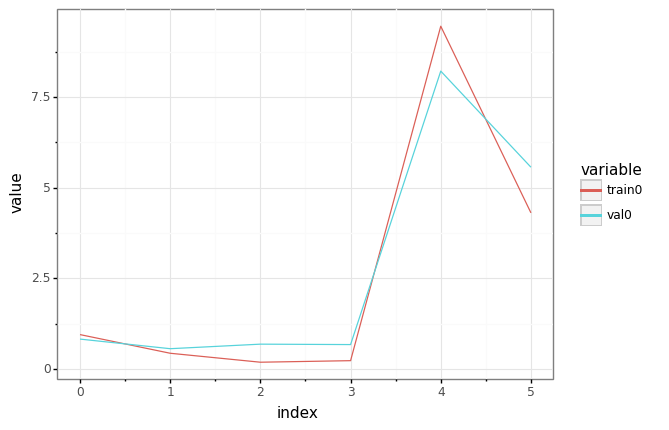

In [29]:
TRAIN_SIZE = 2 ** 14
VALID_SIZE = 128
BATCH_SIZE = 8
SEQ_LEN = 64

train, valid = generate_data(TRAIN_SIZE, VALID_SIZE)

# Plot an observation/target pair.
df = pd.DataFrame({'train0': np.append(train[0][:, 0, 0], train[1][:, 0, 0]), 
                   'val0': np.append(valid[0][:, 0, 0], valid[1][:, 0, 0])}).reset_index()
df = pd.melt(df, id_vars=['index'], value_vars=['train0', 'val0'])
plot = gg.ggplot(df) + gg.aes(x='index', y='value', color='variable') + gg.geom_line()
plot.draw()

train_ds = Dataset(train, BATCH_SIZE)
valid_ds = Dataset(valid, BATCH_SIZE)
del train, valid  # Don't leak temporaries.

##Training an LSTM

To train the LSTM, we define a Haiku function which unrolls the LSTM over the input sequence, generating predictions for all output values. The LSTM always starts with its initial state at the start of the sequence.

The Haiku function is then transformed into a pure function through hk.transform, and is trained with Adam on an L2 prediction loss.

In [40]:
def unroll_net(seqs: jnp.ndarray):
  """Unrolls an LSTM over seqs, mapping each output to a scalar."""
  # seqs is [T, B, F].
  # T is the number of time steps.
  # B batch size
  # F features
  core = hk.LSTM(32)
  batch_size = seqs.shape[1]
  outs, state = hk.dynamic_unroll(core, seqs, core.initial_state(batch_size))
  # We could include this Linear as part of the recurrent core!
  # However, it's more efficient on modern accelerators to run the linear once
  # over the entire sequence than once per sequence element.
  return hk.BatchApply(hk.Linear(1))(outs), state


def net_fn(x) -> jnp.ndarray:
  """https://github.com/deepmind/dm-haiku/blob/main/examples/mnist.py#L30
  """
  mlp = hk.Sequential([
      hk.Flatten(),
      hk.Linear(4), jax.nn.relu,
      hk.Linear(2)
  ])
  return mlp(x)

# model = hk.transform(unroll_net)
model = hk.transform(net_fn)

def train_model(train_ds: Dataset, valid_ds: Dataset) -> hk.Params:
  """Initializes and trains a model on train_ds, returning the final params."""
  rng = jax.random.PRNGKey(428)
  opt = optax.adam(1e-3)

  @jax.jit
  def loss(params, x, y):
    pred = model.apply(params, None, x)
    return jnp.mean(jnp.square(pred - y))

  @jax.jit
  def update(step, params, opt_state, x, y):
    l, grads = jax.value_and_grad(loss)(params, x, y)
    grads, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, grads)
    return l, params, opt_state

  # Initialize state.
  sample_x, _ = next(train_ds)
  params = model.init(rng, sample_x)
  opt_state = opt.init(params)

  for step in range(20001):
    if step % 1000 == 0:
      x, y = next(valid_ds)
      print("Step {}: valid loss {}".format(step, loss(params, x, y)))

    x, y = next(train_ds)
    train_loss, params, opt_state = update(step, params, opt_state, x, y)
    if step % 100 == 0:
      print("Step {}: train loss {}".format(step, train_loss))

  return params

In [41]:
trained_params = train_model(train_ds, valid_ds)

Step 0: valid loss 47.84747314453125
Step 0: train loss 19.67671775817871
Step 100: train loss 38.07251739501953
Step 200: train loss 31.196619033813477
Step 300: train loss 39.87221908569336
Step 400: train loss 21.66625213623047
Step 500: train loss 20.727420806884766
Step 600: train loss 8.787806510925293
Step 700: train loss 15.669486045837402
Step 800: train loss 7.11230993270874
Step 900: train loss 9.558319091796875
Step 1000: valid loss 5.9487152099609375
Step 1000: train loss 6.160392761230469
Step 1100: train loss 8.06402587890625
Step 1200: train loss 6.717275142669678
Step 1300: train loss 5.102151393890381
Step 1400: train loss 4.56059455871582
Step 1500: train loss 2.6653473377227783
Step 1600: train loss 6.950912952423096
Step 1700: train loss 3.3794634342193604
Step 1800: train loss 3.1752917766571045
Step 1900: train loss 2.247728109359741
Step 2000: valid loss 5.492514610290527
Step 2000: train loss 4.3490071296691895
Step 2100: train loss 1.1991899013519287
Step 2200

## Sampling

The point of training models is so that they can make predictions! How can we generate predictions with the trained model?

If we're allowed to feed in the ground truth, we can just run the original model's apply function.

In [42]:
def plot_samples(truth: np.ndarray, prediction: np.ndarray) -> gg.ggplot:
  assert truth.shape == prediction.shape
  df = pd.DataFrame({'truth': truth.squeeze(), 'predicted': prediction.squeeze()}).reset_index()
  df = pd.melt(df, id_vars=['index'], value_vars=['truth', 'predicted'])
  plot = (
      gg.ggplot(df)
      + gg.aes(x='index', y='value', color='variable')
      + gg.geom_line()
  )
  return plot

predicted=(1, 2)
truth_y=(1, 2)


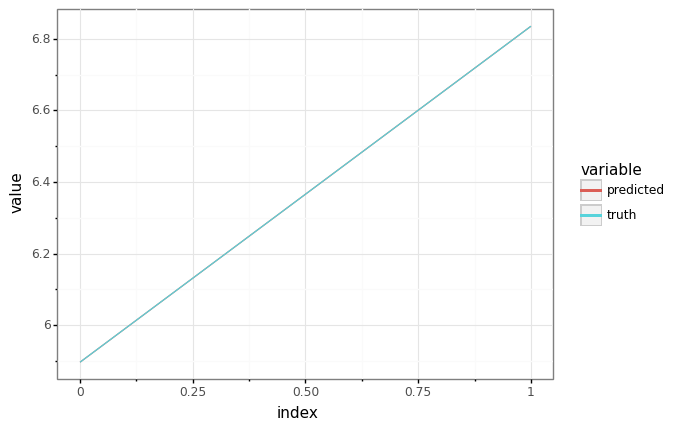

In [43]:
# Grab a sample from the validation set.
sample_x, sample_y = next(valid_ds)
sample_x = sample_x[:1, :]  # Shrink to batch-size 1.
truth_y = sample_y[:1, :]

# Generate a prediction, feeding in ground truth at each point as input.
predicted = model.apply(trained_params, None, sample_x)

print(f'predicted={predicted.shape}')
print(f'truth_y={truth_y.shape}')

plot = plot_samples(truth_y, predicted)
plot.draw()
del sample_x, predicted

# Typically: the beginning of the predictions are a bit wonky, but the curve
# quickly smoothes out.